# Claude + E2B Code interpreter

**Powered by [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)**


E2B's code interpreter SDK quickly creates a secure cloud sandbox powered by [Firecracker](https://github.com/firecracker-microvm/firecracker).

Inside this sandbox is a running Jupyter server that the LLM can use.

In [6]:
%pip install e2b_code_interpreter==1.0.0 anthropic==0.35.0 python-dotenv==1.0.1

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
from dotenv import load_dotenv
load_dotenv()

# TODO: Get your Anthropic API key from https://anthropic.com
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")


# MODEL_NAME = "claude-3-opus-20240229"
MODEL_NAME = 'claude-3-5-sonnet-20241022'

SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.

## style guide
tool response values that have text inside "[]"  mean that a visual element got rended in the notebook. for example:
- "[chart]" means that a chart was generated in the notebook.
"""

tools = [
    {
        "name": "execute_python",
        "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
        "input_schema": {
            "type": "object",
            "properties": {
                "code": {
                    "type": "string",
                    "description": "The python code to execute in a single cell."
                }
            },
            "required": ["code"]
        }
    }
]

In [8]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.run_code(code,
  on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
  on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [9]:
from anthropic import Anthropic
client = Anthropic(
    api_key=ANTHROPIC_API_KEY,
)

def process_tool_call(e2b_code_interpreter, tool_name, tool_input):
    if tool_name == "execute_python":
        return code_interpret(e2b_code_interpreter, tool_input["code"])
    return []

def chat_with_claude(e2b_code_interpreter, user_message):
    print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

    message = client.messages.create(
        model=MODEL_NAME,
        system=SYSTEM_PROMPT,
        max_tokens=4096,
        messages=[{"role": "user", "content": user_message}],
        tools=tools,
    )

    print(f"\nInitial Response:")
    print(f"Stop Reason: {message.stop_reason}")
    print(f"Content: {message.content}")

    if message.stop_reason == "tool_use":
        tool_use = next(block for block in message.content if block.type == "tool_use")
        tool_name = tool_use.name
        tool_input = tool_use.input

        print(f"\nTool Used: {tool_name}")
        print(f"Tool Input: {tool_input}")

        code_interpreter_results = process_tool_call(e2b_code_interpreter, tool_name, tool_input)

        print(f"Tool Result: {code_interpreter_results}")
        return code_interpreter_results


User Message: Calculate value of pi using monte carlo method. Use 1000 iterations. Visualize all point of all iterations on a single plot, a point inside the unit circle should be green, other points should be gray.

Initial Response:
Stop Reason: tool_use
Content: [TextBlock(text="I'll help you calculate π using the Monte Carlo method and create a visualization. This method works by randomly generating points in a 2x2 square centered at the origin and checking if they fall within a unit circle. The ratio of points inside the circle to total points, multiplied by 4, approximates π.\n\nHere's the implementation:", type='text'), ToolUseBlock(id='toolu_017TZQEhkoD1yhvTkMewXmTH', input={'code': 'import numpy as np\nimport matplotlib.pyplot as plt\n\n# Set random seed for reproducibility\nnp.random.seed(42)\n\n# Generate random points\nn_points = 1000\nx = np.random.uniform(-1, 1, n_points)\ny = np.random.uniform(-1, 1, n_points)\n\n# Calculate distances from origin\ndistances = np.sqrt(x*

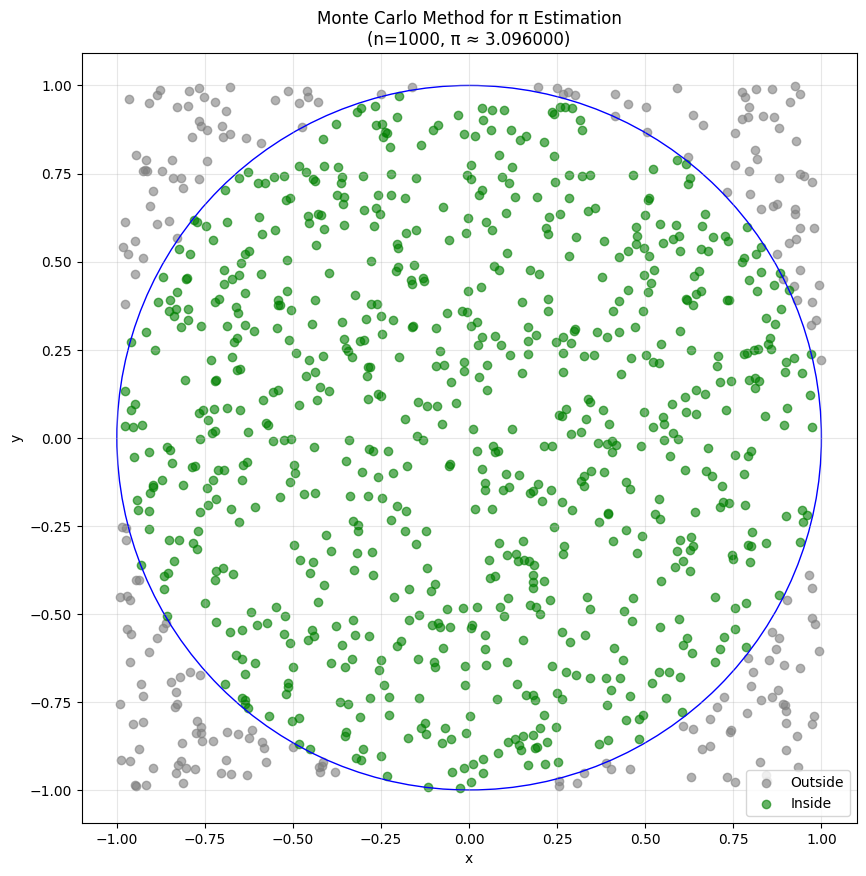

In [10]:
from e2b_code_interpreter import Sandbox

with Sandbox(api_key=E2B_API_KEY) as code_interpreter:
  code_interpreter_results = chat_with_claude(
    code_interpreter,
    "Calculate value of pi using monte carlo method. Use 1000 iterations. Visualize all point of all iterations on a single plot, a point inside the unit circle should be green, other points should be gray.",
  )
  result = code_interpreter_results[0]
  print(result)

# This will render the image
# You can also access the data directly
# result.png
# result.jpg
# result.pdf
# ...
result